In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr
from tools import savefig, fix_figure, coef_var, corrcoef, set_style
import copy
from IPython.display import display

,rate_in,rate_ex
0,10.398534,10.070961


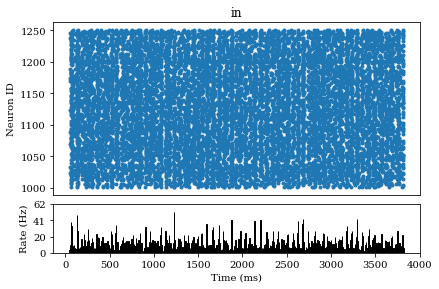

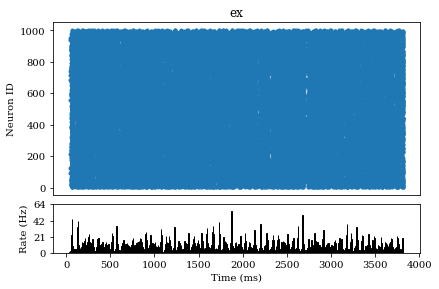

In [66]:
from params_1 import parameters
sim = Simulator(parameters, fname='voltage_dist_AI', data_path='results', 
#                 stim_N=9, stim_period=500, stim_max_period=600, stim_dist='poisson', stim_amp_ex=10.0,
                stim_N=30, stim_period=100, stim_dist='poisson', stim_amp_ex=0., stim_N_ex=800,
                N_rec_state_ex=100, N_rec_state_in=100, sampling_period=1.)
sim.simulate(state=True, save=True, raster=True)

# from params_SI import parameters
# sim = Simulator(parameters, fname='voltage_dist_SI', data_path='results', 
#                 stim_N=9, stim_period=500, stim_dist=None, stim_amp_ex=10.0,
#                 N_rec_state_ex=100, N_rec_state_in=1)
# sim.simulate(state=True, save=True, raster=True)

pd.DataFrame([sim.data['params']]).loc[:,['rate_in', 'rate_ex']]

In [67]:
epoch = sim.data['epoch']['times']
spiketrains = [sptr['times'] for sptr in sim.data['spiketrains']['ex']
               if sptr['sender'] in sim.data['stim_nodes']['ex']]

In [68]:
lats = []
for s in spiketrains:
    lat = []
    for e in epoch:
        l = s - e
        l = l[l>0]
        if len(l) > 0:
            lat.append(min(l))
        else:
            lat.append(np.nan)
    lats.append(lat)
lats = np.array(lats) 

In [69]:
for j in range(len(epoch)):
    diff = []
    ls = lats[:,j]
    for i, l in enumerate(ls):
        _ls = np.delete(ls, i)
        diff.append(_ls - l)
    diff = np.array(diff).flatten()
    bins = np.arange(0, 20,.1)
    plt.hist(diff[~np.isnan(diff)], bins=bins);
    plt.title('Trial {}'.format(j))
#     plt.ylim([0,500])
    plt.gcf().savefig('fig/fig_{}.png'.format(j))
    plt.close(plt.gcf())

In [70]:
state_ex = sim.data['state']['ex']
states = np.array([state_ex['V_m'][state_ex['times'] == e+2] for e in epoch]).T

In [71]:
bins = np.arange(0,20,.1)
for j in range(len(epoch)):
    diff = []
    ls = states[:,j]
    for i, l in enumerate(ls):
        _ls = np.delete(ls, i)
        diff.append(_ls - l)
    diff = np.array(diff).flatten()
    plt.hist(diff, bins=bins);
    plt.title('Trial {}'.format(j))
#     plt.ylim([0,500])
    plt.gcf().savefig('fig/fig_{}.png'.format(j))
    plt.close(plt.gcf())

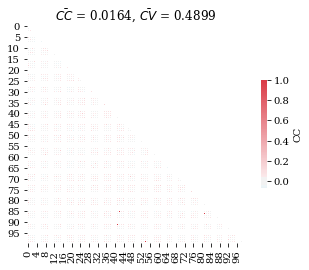

In [72]:
N = 100
binsize = 5

idx = np.random.randint(1,1000, N)
t_stop = sim.data['params']['status']['time']
spiketrains = [sim.data['spiketrains']['ex'][i]['times'] for i in idx
              if i < len(sim.data['spiketrains']['ex'])]

cv = np.array([np.diff(t).std()/np.diff(t).mean()
               for t in [s['times'] for s in sim.data['spiketrains']['ex']] 
               if len(t) > 1])

ccg = corrcoef(spiketrains, t_stop, binsize)
m = np.triu(ccg, k=1)
mask = np.zeros_like(ccg, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ccg, mask=mask, cmap=cmap, vmax=m.max(), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, 'label': 'CC'})
plt.title('$\\bar{{CC}}$ = {:.4f}, $\\bar{{CV}}$ = {:.4f}'.format(m.mean(), cv.mean()));

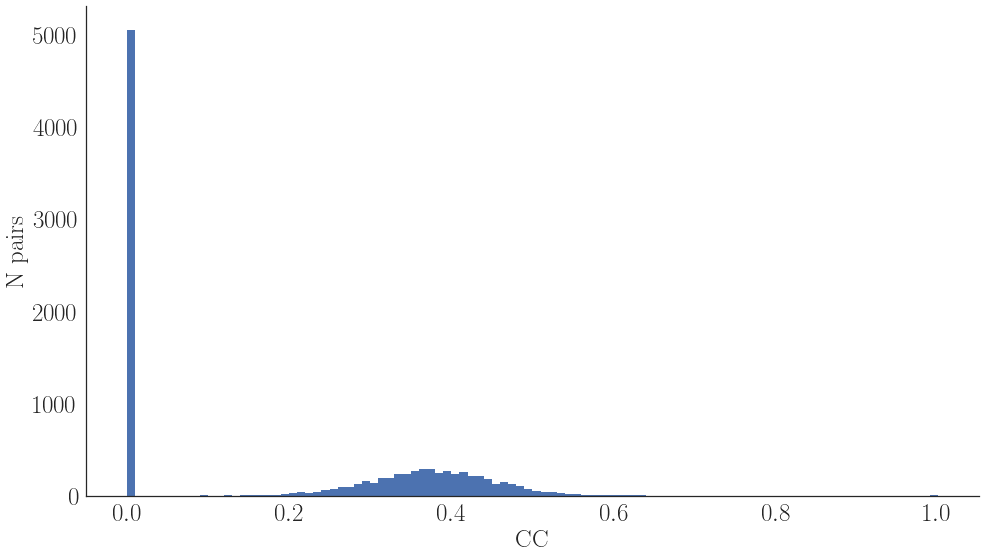

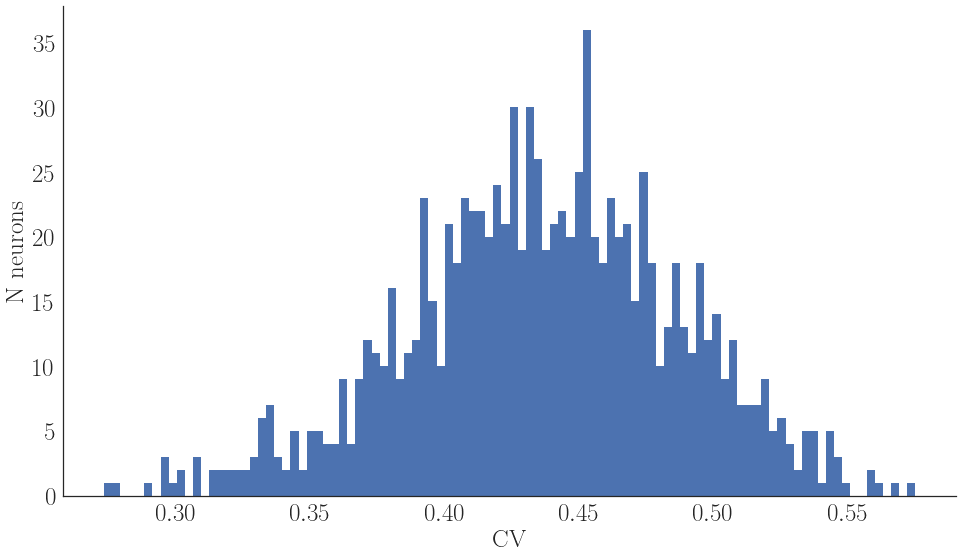

In [4]:
set_style('notebook', w=0.485)
plt.figure()
plt.hist(m.flatten(), bins=100);
plt.xlabel('CC')
plt.ylabel('N pairs')
sns.despine()
# savefig(plt.gcf(), 'CC')

plt.figure()
plt.hist(cv, bins=100);
plt.xlabel('CV')
plt.ylabel('N neurons')
sns.despine()
# savefig(plt.gcf(), 'CV')

In [13]:
data = sim.data
# data = np.load('results/voltage_dist_AI.npz')['data'][()]
# data = np.load('results/voltage_dist_SI.npz')['data'][()]

In [14]:
pop = 'ex'
senders = data['state'][pop]['senders']
V = data['state'][pop]['V_m']
senders_unique = list(set(senders))
nsamples = sum(senders==senders_unique[0])
nsenders = len(senders_unique)
state = np.zeros((nsenders, nsamples))
for i, sender in enumerate(senders_unique):
    state[i,:] = V[senders==sender]
times = data['state'][pop]['times'][senders==sender]

In [8]:
df = pd.DataFrame(state, index=senders_unique, columns=times.round())

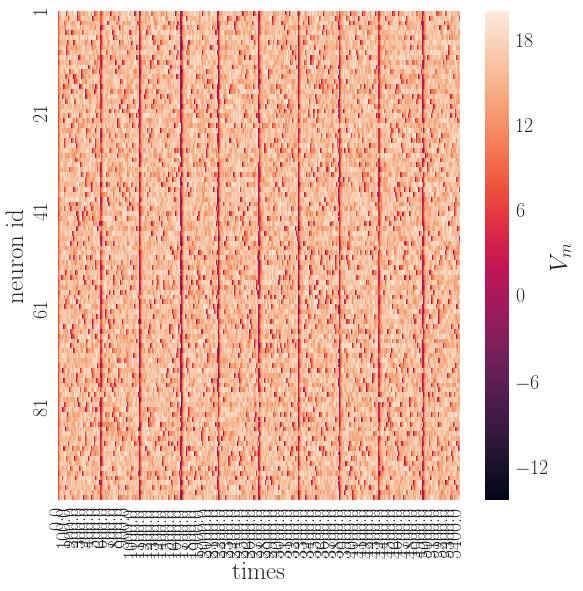

In [9]:
df.index.name = 'neuron id'
df.columns.name = 'times'
sns.heatmap(df, cbar_kws={'label': '$V_m$'},
           xticklabels=1000, yticklabels=20)

In [15]:
bins = np.arange(-20, 20, .5)
t = times[::10]
hist = np.zeros((len(bins)-1, len(t)))
for ii, pot in enumerate(state[:,::10].T):
    h, b = np.histogram(pot, bins=bins, density=True)
    hist[:,ii] = h[::-1]

In [16]:
df_hist = pd.DataFrame(hist, index=bins[::-1][:-1].round(), columns=t.round())

In [17]:
df_hist[df_hist==0] = 1e-6

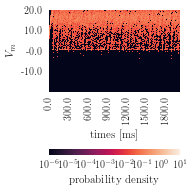

In [40]:
set_style('article', w=0.47, h=1.5)
from matplotlib.colors import LogNorm
df_hist.index.name = '$V_m$'
df_hist.columns.name = 'times [ms]'
cbar_kws = {'label': 'probability density',
            'orientation':'horizontal',
            'pad': 0.35,
            'ticks': [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]}
axs = sns.heatmap(df_hist, cbar_kws=cbar_kws,
                  norm=LogNorm(vmin=df_hist.min(), vmax=df_hist.max()),
                  vmin=min(cbar_kws['ticks']), vmax=max(cbar_kws['ticks']),
                 xticklabels=300, yticklabels=20)
savefig(plt.gcf(), 'mem_dist', bbox_inches='tight', ext='png', dpi=300)

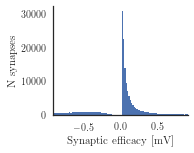

In [28]:
set_style('article', w=0.485)
conn = sim.data['connections']
plt.hist(conn.weight, bins=100);
plt.xlim([conn.weight.min(), conn.weight.max()])
plt.xlabel('Synaptic efficacy [mV]')
plt.ylabel('N synapses')
sns.despine()
savefig(plt.gcf(), 'syn_dist')